In [18]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

from scipy.signal import butter, lfilter
from collections import deque

import os
import glob

In [19]:
# -----------------------------
# RMS envelope (stateful)
# -----------------------------
class RMSOnline:
    def __init__(self, fs, window_ms=50):
        self.N = int(fs * window_ms / 1000)
        self.buf = deque(maxlen=self.N)
        self.running_sum_of_squares = 0.0

    def process(self, x):
        out = np.zeros_like(x)
        for i, s in enumerate(x):
            if len(self.buf) == self.N:
                self.running_sum_of_squares -= self.buf[0] ** 2
            self.buf.append(s)
            self.running_sum_of_squares += s ** 2
            out[i] = np.sqrt(self.running_sum_of_squares / len(self.buf))
        return out

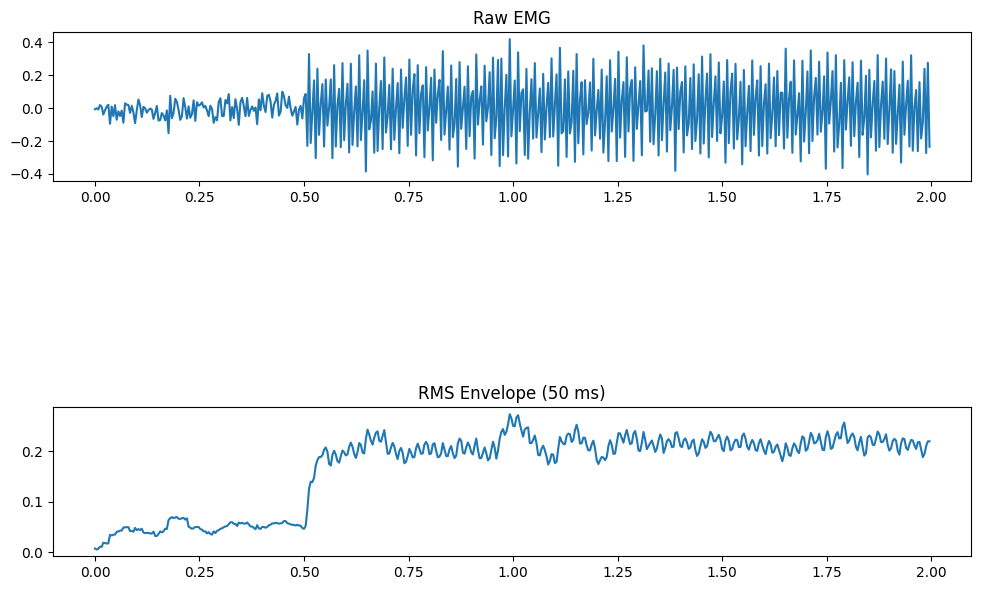

In [20]:
fs = 250  # Hz
duration = 2.0
t = np.arange(0, duration, 1/fs)

# Fake EMG-like signal
raw_emg = 0.05 * np.random.randn(len(t))
raw_emg += 0.3 * np.sin(2 * np.pi * 100 * t) * (t > 0.5)

# Create pipeline
rms = RMSOnline(fs, window_ms=50)

# Simulate streaming in chunks
chunk_size = 64
envelope = []

for i in range(0, len(raw_emg), chunk_size):
    chunk = raw_emg[i:i+chunk_size]
    e = rms.process(chunk)
    envelope.append(e)

envelope = np.concatenate(envelope)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
plt.plot(t, raw_emg)
plt.title("Raw EMG")

plt.subplot(3,1,3)
plt.plot(t, envelope)
plt.title("RMS Envelope (50 ms)")

plt.tight_layout()
plt.show()

In [14]:
def normalize_input(x: np.ndarray):
  row_max = x.max(axis=1, keepdims=True)
  x = x / row_max
  return x

In [21]:
# Define path were emg data is stored into folders belonging to each class (Task1, Task2, ...)
MAIN_PATH = "./Data/"
# Define path to save generated features
FEATURES_PATH = "./Features"
TARGETS_PATH = "./Targets"

TRAINING_DATA_PATH = "../gesture_recognition/training_data"

# List containing the name of each folder representing each class
CLASS_DICT = {
    "forward": 1,
    "backward": 2,
    "left": 3,
    "right": 4,
    "stop": 5,
    "jump": 6
}

NUM_CLASSES = len(CLASS_DICT)

# In case you want to add a feature, you should generate your own function and add the case on the function: get_custom_features()
FEATURES = ["MeanAbsValue", "MeanAbsWeightHalf", "MeanAbsWeight2", "Variance", "Max", "Min"]

EMG_SENSORS = ["SENS1", "SENS2", "SENS3", "SENS4"]
NUM_SENSORS = len(EMG_SENSORS)

In [50]:
def mean_abs_value_with_bias(data: pd.Series, weight: float = 1.0, window_length = 0.25) -> float:
  if (weight == 1.0):
    return abs(data).mean()

  values_list = []
  for id in range(len(data)):
    if id + 1 <= (1-window_length)*len(data) and id + 1 >= window_length*len(data):
      w = 1
    else:
      w = weight
    values_list.append(abs(data.iloc[id])*w)
  return np.mean(values_list)

def variance(data: pd.Series):
  variance = data.var()
  return variance

def max_val(data: pd.Series):
  return data.max()

def min_val(data: pd.Series):
  return data.min()

In [51]:

FEATURES_LIST = []

FEATURES_LIST.append("Target")
for feature in FEATURES:
    for sensor in EMG_SENSORS:
        FEATURES_LIST.append(f"{feature}_{sensor}")

print(FEATURES_LIST)

['Target', 'MeanAbsValue_SENS1', 'MeanAbsValue_SENS2', 'MeanAbsValue_SENS3', 'MeanAbsValue_SENS4', 'MeanAbsWeightHalf_SENS1', 'MeanAbsWeightHalf_SENS2', 'MeanAbsWeightHalf_SENS3', 'MeanAbsWeightHalf_SENS4', 'MeanAbsWeight2_SENS1', 'MeanAbsWeight2_SENS2', 'MeanAbsWeight2_SENS3', 'MeanAbsWeight2_SENS4', 'Variance_SENS1', 'Variance_SENS2', 'Variance_SENS3', 'Variance_SENS4', 'Max_SENS1', 'Max_SENS2', 'Max_SENS3', 'Max_SENS4', 'Min_SENS1', 'Min_SENS2', 'Min_SENS3', 'Min_SENS4']


In [52]:
GROUP_SIZE = 10

def create_emg_csvs(path: str):
  # Upload emg data for csvs under MAIN_PATH

  dataframe_list = []
  num_groups = 0

  for file in glob.iglob(os.path.join(TRAINING_DATA_PATH, "*/*.jsonl")):
    df = pd.read_json(file, lines=True)
    dataframe_list.append(df)
    num_groups += len(df) // GROUP_SIZE * NUM_SENSORS

  output_df = pd.DataFrame(index=range(num_groups), columns=["sensor", "target"] + [f"DATA_{i}" for i in range(GROUP_SIZE)])

  row_id = 0
  for df in dataframe_list:
    gesture = df["gesture"]
    for i in range(0, len(df), GROUP_SIZE):
      sensor_vals = df["data"].iloc[i:i + GROUP_SIZE]
      block = np.stack(sensor_vals.to_numpy())
      grouped = block.T
      grouped = normalize_input(grouped)
      for j in range(NUM_SENSORS):
        output_df.iloc[row_id]["sensor"] = EMG_SENSORS[j]
        ouptut_df.iloc[row_id]["target"] = CLASS_DICT[gesture]
        for k in range(GROUP_SIZE):
          output_df.iloc[f"DATA_{k}"] = grouped[j][k]
        row_id += 1

  output_df.to_csv(f"{MAIN_PATH}/emg.csv")

  # Write pd.DataFrame under path

def main(path: str) -> pd.DataFrame:
    """
    This function iterates through the path containing all
    emg files and calculate the different features for each
    emg sensor.
    Params:
        path (str): path to the folders containing all emg files.
    Returns:
        df_features (Dataframe): contains features from all files
    """

    total_rows = 0

    for file in glob.iglob(os.path.join(path, "*/*.csv")):
        emg_file = pd.read_csv(file, index_col=0)
        total_rows += len(emg_file)

    # Define main dataframe to store calculated features
    df_features = pd.DataFrame(np.nan, index=range(total_rows), columns=FEATURES_LIST)

    # Iterate through emg files in path
    row_id = 0
    for file in glob.iglob(os.path.join(path, "*/*.csv")):
        emg_file = pd.read_csv(file, index_col = 0)
        # Iterate through each emg sensor
        for sensor in EMG_SENSORS:
            # Iterate through each feature type
            emg_sensor_rows = emg_file[emg_file["sensor"] == sensor]
            for row in emg_sensor_rows:
              feature_file = {}
              # Store task target
              feature_file["Target"] = row["target"]
              row_data = row.drop(["sensor", "target"])
              for feature in FEATURES:
                  match feature:
                      case "MeanAbsValue":
                          value = mean_abs_value_with_bias(row_data)
                      case "MeanAbsWeightHalf":
                          value = mean_abs_value_with_bias(row_data, weight = 0.5)
                      case "MeanAbsWeight2":
                          value = mean_abs_value_with_bias(row_data, weight = 2.0)
                      case "Variance":
                          value = variance(row_data)
                      case "Max":
                          value = max_val(row_data)
                      case "Min":
                          value = min_val(row_data)
                      case _:
                          value = np.nan
                  # Store calculated feature in dict
                  feature_file[f"{feature}_{sensor}"] = (value)
              df_features[row_id] = feature_file
              row_id += 1
    return df_features

In [ ]:
df_custom_features = main(MAIN_PATH)

In [ ]:
df_custom_features.to_csv(os.path.join(FEATURES_PATH, "custom_features.csv"), index=False)

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Define training hyperparameters
TRAIN_SIZE = 0.6
VAL_SIZE = 0.2
TEST_SIZE = 0.2
LEARNING_RATE = 0.01
EPOCHS = 300
BATCH_SIZE = 32
RANDOM_STATE = 42

# Define paths for saving trained model and plots
MODELS_DIR = '../models/'
PLOT_DIR = '../plots/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
if not os.path.exists(PLOT_DIR):
    os.mkdir(PLOT_DIR)

MODEL_PATH = os.path.join(MODELS_DIR, 'model.pth')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Read features from csv files
print("Loading data...")
df_features = pd.read_csv(os.path.join(FEATURES_PATH, "custom_features.csv"))

# Remove any NaN values
df_features.dropna(inplace=True)

# Get number of classes
num_classes = len(df_features["Target"].unique())
print(f'Number of classes: {num_classes}')

# Separate features and labels using column names
X = df_features.drop('Target', axis=1).values.astype('float32')
y = df_features['Target'].values.astype(int)

print(f'Input feature dimension: {X.shape[1]}')
print(f'Total samples: {X.shape[0]}')

# Split data: 60% train, 20% validation, 20% test
# First split: 60% train, 40% temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=(VAL_SIZE + TEST_SIZE),
    random_state=RANDOM_STATE,
    stratify=y  # Ensure balanced class distribution
)

# Second split: Split temp into 50% validation, 50% test (each 20% of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,  # 50% of 40% = 20% of total
    random_state=RANDOM_STATE,
    stratify=y_temp
)

print(f'Train samples: {X_train.shape[0]}')
print(f'Validation samples: {X_val.shape[0]}')
print(f'Test samples: {X_test.shape[0]}')

# Verify split percentages
total = X.shape[0]
print(f'\nSplit verification:')
print(f'  Train: {X_train.shape[0]/total*100:.1f}%')
print(f'  Val:   {X_val.shape[0]/total*100:.1f}%')
print(f'  Test:  {X_test.shape[0]/total*100:.1f}%')

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
X_val = torch.FloatTensor(X_val).to(device)
y_val = torch.LongTensor(y_val).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.LongTensor(y_test).to(device)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# Define model
class EMGClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EMGClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)
        self.fc4 = nn.Linear(10, num_classes)
        self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(0.2)  # Uncomment to add dropout

    def forward(self, x):
        x = self.relu(self.fc1(x))
        # x = self.dropout(x)
        x = self.relu(self.fc2(x))
        # x = self.dropout(x)
        x = self.relu(self.fc3(x))
        # x = self.dropout(x)
        x = self.fc4(x)  # No activation here, CrossEntropyLoss includes softmax
        return x


model = EMGClassifier(X_train.shape[1], num_classes).to(device)
print("\nModel Architecture:")
print(model)
print(f'\nTotal parameters: {sum(p.numel() for p in model.parameters())}')

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training function
def train_epoch(model, loader, criterion, optimizer, desc="Training"):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc=desc, leave=False)
    for batch_x, batch_y in pbar:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100. * correct / total:.2f}%'
        })

    return total_loss / len(loader), correct / total

# Validation function
def validate(model, loader, criterion, desc="Validating"):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc=desc, leave=False)
    with torch.no_grad():
        for batch_x, batch_y in pbar:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100. * correct / total:.2f}%'
            })

    return total_loss / len(loader), correct / total

# Train model
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("\n" + "="*60)
print("Starting training...")
print("="*60 + "\n")
start = time.time()

epoch_pbar = tqdm(range(EPOCHS), desc="Overall Progress")
for epoch in epoch_pbar:
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer,
        desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"
    )
    val_loss, val_acc = validate(
        model, val_loader, criterion,
        desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"
    )

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Update epoch progress bar
    epoch_pbar.set_postfix({
        'train_loss': f'{train_loss:.4f}',
        'train_acc': f'{train_acc:.4f}',
        'val_loss': f'{val_loss:.4f}',
        'val_acc': f'{val_acc:.4f}'
    })

stop = time.time()
print(f"\n{'='*60}")
print(f"Training completed in {stop - start:.2f}s")
print(f"{'='*60}\n")

# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_acc = validate(model, test_loader, criterion, desc="Testing")
print(f'\nTest Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)')

# Calculate additional metrics (Precision, Recall, F1)
print("\nGenerating predictions for detailed metrics...")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in tqdm(test_loader, desc="Predicting", leave=False):
        outputs = model(batch_x)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(all_labels, all_preds))

print("\n" + "="*60)
print("Confusion Matrix:")
print("="*60)
print(confusion_matrix(all_labels, all_preds))

# Plot accuracy history
print("\nGenerating plots...")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train', linewidth=2)
plt.plot(history['val_acc'], label='Validation', linewidth=2)
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Plot loss history
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train', linewidth=2)
plt.plot(history['val_loss'], label='Validation', linewidth=2)
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'training_history.jpg'), dpi=150)
print(f"Plots saved to {os.path.join(PLOT_DIR, 'training_history.jpg')}")
plt.show()

# Save PyTorch model
print("\nSaving model...")
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': EPOCHS,
    'history': history,
    'train_acc': history['train_acc'][-1],
    'val_acc': history['val_acc'][-1],
    'test_acc': test_acc,
    'num_classes': num_classes,
    'input_size': X_train.shape[1]
}, MODEL_PATH)

print(f'Model saved to {MODEL_PATH}')

print("\n" + "="*60)
print("Training Summary:")
print("="*60)
print(f"Final Train Accuracy: {history['train_acc'][-1]:.4f} ({history['train_acc'][-1]*100:.2f}%)")
print(f"Final Val Accuracy:   {history['val_acc'][-1]:.4f} ({history['val_acc'][-1]*100:.2f}%)")
print(f"Test Accuracy:        {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Training Time:        {stop - start:.2f}s")
print("="*60)

# Example code to load the model later:
print("\n# To load the model later, use:")
print("# checkpoint = torch.load('{}')".format(MODEL_PATH))
print("# model = EMGClassifier(checkpoint['input_size'], checkpoint['num_classes'])")
print("# model.load_state_dict(checkpoint['model_state_dict'])")
print("# model.eval()")